# Problem Description

The problem i design for first problem is pretty common in school life. Assuming next week in one week Bob will have a test, but the day of test has not been decided yet. Alice is one of Bob's classmate. The probability of two students going to school under different situation is different. Now, given two students meet at school one day in next week, please calulate the probability of Bob having test at that day.

# Making a Model

According to the background mentioned above, we could draw a graph to make sure every relationship between every reason and result. The relationship involed in this problem is shown below.

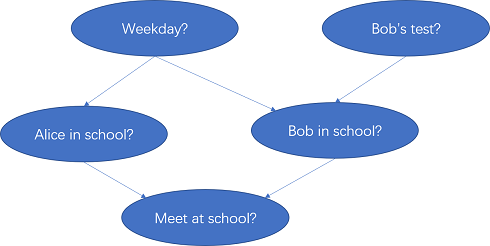

The "weekday?" means the probability of one day is weekday. Obviously the true answer's probability is 5/7, false is 2/7.

The "Bob's  test?" means the probability of Bob has test in this day. Assuming the probability of true is 1/7, false is 6/7.

The probability of Alice and Bob meet at school is 0.3.

The event Alice going to school is influenced by its parent "Weekday". Hence, the distribution of this event could been displayed in this table.

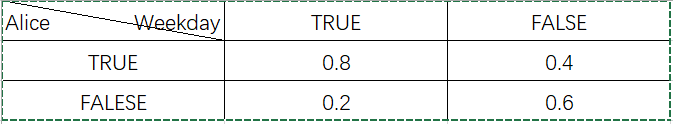

The event Bob going to school is influenced by two parents: "Weekday?" and "Have test"?  The probability distribution is shown as below.

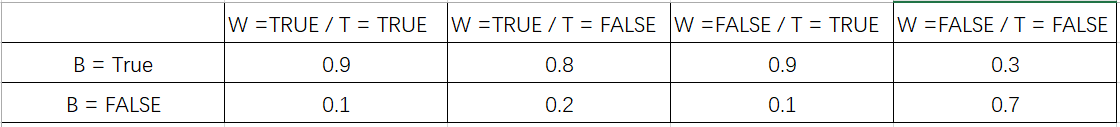

Here B means Bob goes to school.

W means todaty is weekday.

T means Bob has test today.

# Creat network 

The following part is using two package Pymc3 and Pgmpy to same a same problem. Given the condition, Alice and Bob meet at school, calulate the probability that Bob has test at that day.

This is pymc3 part:

In [28]:
import pymc3

# define model
model = pymc3.Model()

In [29]:
from pymc3 import Bernoulli

with model:
    Weekday = Bernoulli('Weekday', 5/7)
    BobTest = Bernoulli('BobTest',1/7)

In [30]:
from pymc3.math import switch

with model:
    Alice = Bernoulli('Alice', switch(Weekday, 0.8, 0.4))
   
    Bob = Bernoulli('Bob', switch(Weekday,switch(BobTest,0.9,0.8),switch(BobTest, 0.9, 0.3)))
    
    Meet = Bernoulli('Meet', switch(Alice and  Bob, 0.3, 0))

Create 10000 sample:

Multiprocess sampling (4 chains in 2 jobs)
BinaryGibbsMetropolis: [Weekday, BobTest, Alice, Bob, Meet]


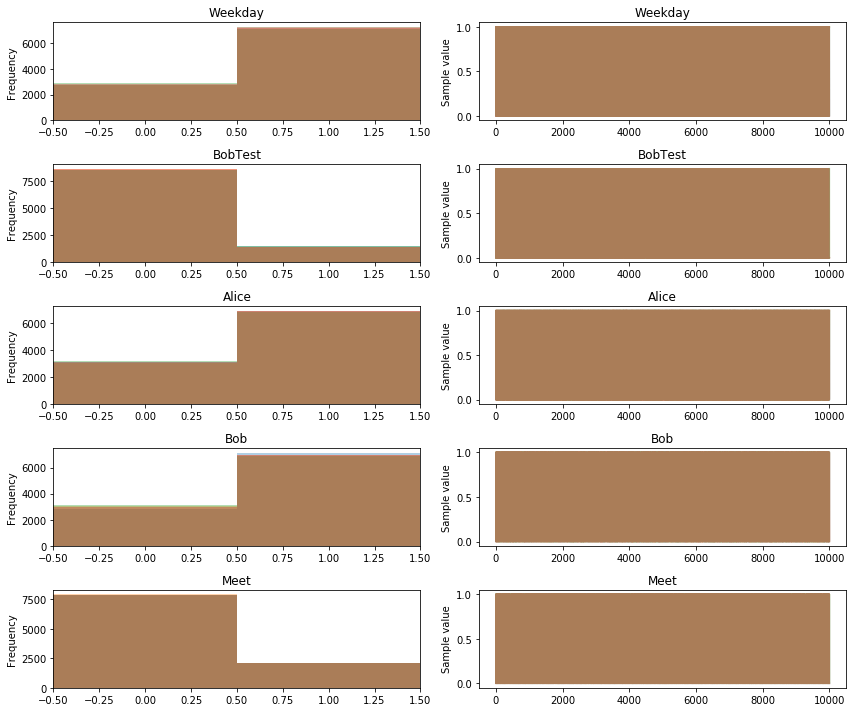

In [31]:
%matplotlib inline

nsamples = 10000

with model:
    trace = pymc3.sample(nsamples, chains=4)
    pymc3.traceplot(trace)
    

In [15]:
def calcCondProb(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

In [84]:
print('P(BobTest = true | Meet = true) = ', 
      calcCondProb(trace, {'BobTest' : 1}, {'Meet' : 1}))
print('P(BobTest = true | Bob = true) =', 
      calcCondProb(trace, {'BobTest' : 1}, {'Bob' : 1}))

P(BobTest = true | Meet = true) =  0.17498811222063718
P(BobTest = true | Bob = true, Alice = true) = 0.18421429594613953


This is pgmpy part:

In [76]:
from pgmpy.models import BayesianModel as bysmodel

# define model with specifying connections between random variables
model = bysmodel([('Weekday', 'Alice'), ('Weekday', 'Bob'), ('BobTest', 'Bob'),('Bob', 'Meet'),('Alice', 'Meet')]);

In [77]:
from pgmpy.factors.discrete import TabularCPD as tcpd

# define prior with TabularCPD
priorR = tcpd(variable='Weekday', variable_card=2, values=[[2/7, 5/7]])
priorS = tcpd(variable='BobTest', variable_card=2, values=[[6/7, 1/7]])

# define likelihood with TabularCPD
cpdJ = tcpd(variable='Alice', variable_card=2,
            evidence=['Weekday'], evidence_card=[2],
            values=[[0.4, 0.2],
                    [0.6, 0.8]]
           )

cpdT = tcpd(variable='Bob', variable_card=2,
            evidence=['Weekday', 'BobTest'], evidence_card=[2, 2],
            values=[[0.7, 0.1, 0.2, 0.1],
                    [0.3, 0.9, 0.8, 0.9]]
           )
cpdW = tcpd(variable='Meet', variable_card=2,
            evidence=['Alice', 'Bob'], evidence_card=[2, 2],
            values=[[1, 1, 1, 0.7],
                    [0, 0, 0, 0.3]]
           )

# add probabilities to model
model.add_cpds(priorR, priorS, cpdJ, cpdT,cpdW)

# check structure and values consistency with Bayesian Model
model.check_model()

True

In [81]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

In [82]:
print(infer.query(['BobTest'], evidence={'Meet' : 1}) ['BobTest'])

╒═══════════╤════════════════╕
│ BobTest   │   phi(BobTest) │
╞═══════════╪════════════════╡
│ BobTest_0 │         0.8203 │
├───────────┼────────────────┤
│ BobTest_1 │         0.1797 │
╘═══════════╧════════════════╛


In [85]:
print(infer.query(['BobTest'], evidence={'Bob' : 1}) ['BobTest'])

╒═══════════╤════════════════╕
│ BobTest   │   phi(BobTest) │
╞═══════════╪════════════════╡
│ BobTest_0 │         0.8142 │
├───────────┼────────────────┤
│ BobTest_1 │         0.1858 │
╘═══════════╧════════════════╛


Comparing two result of two package, two probability are very close. One is 0.17498811222063718, another is 0.1797. 